Many people around the world drink wine. It is an elegant and social drink, so it is considered harmonious on every occasion. At the same time, the red wine industry is developing rapidly. The field of data science is becoming an integral part of this industry and one of the main tasks is how to form wine prices in the most efficient way based on the opinions of many wine testers that can vary. The main goal of this analysis is to generate insights that will help us select indicators of red wine quality and build as accurate models as possible.

In [1]:
# Importing all necessary libraries and dataset 
import os
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
os.chdir('/Users/uroszivanovic/Downloads/')
wine = pd.read_csv("winequality-red.csv", delimiter=';')

There are rows of duplicates but since there are no identifiers of users who have, say, tested the wine, it can be said that it is a particular type of wine tested by multiple experts. No missing values in this dataset.

In [2]:
print(wine.isnull().sum())
print(wine.duplicated())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
0       False
1       False
2       False
3       False
4        True
        ...  
1594    False
1595    False
1596     True
1597    False
1598    False
Length: 1599, dtype: bool


Spliting data into train and test set, setting proper column names and the response type as categorical for the purpose of visualizang data.

In [3]:
wine.columns = wine.columns.str.replace(" ", "_")
column_names = wine.columns
predictors = column_names[0:11]
from pandas.api.types import CategoricalDtype
wine["quality1"] = ['Q'] + wine["quality"].astype(str)
from sklearn.model_selection import train_test_split
train_set, test_set = sklearn.model_selection.train_test_split(wine, train_size=0.9, test_size=0.1, random_state = 1)
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

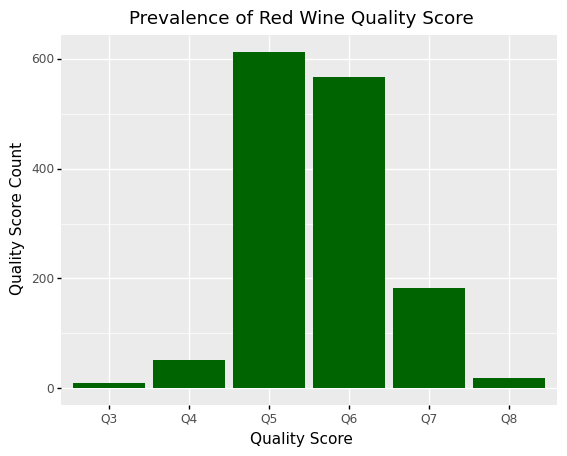

<ggplot: (8778604168879)>

In [4]:
(ggplot(train_set) + 
 geom_bar(aes(x = "quality1"), fill = "darkgreen") +
 labs(
        title ='Prevalence of Red Wine Quality Score',
        x = 'Quality Score',
        y = 'Quality Score Count',
    ))

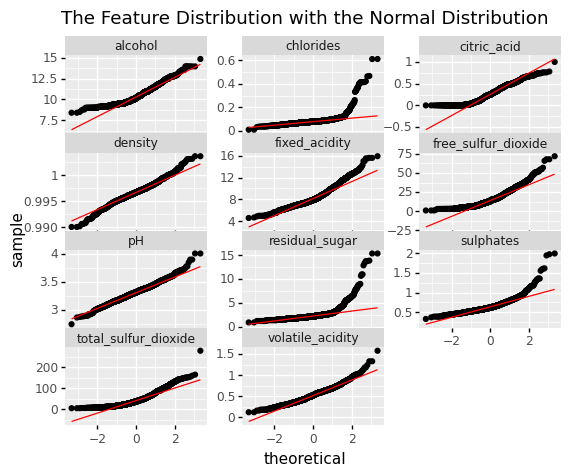

<ggplot: (8778597756916)>

In [5]:
table_1=train_set.melt(id_vars='quality1', value_vars=predictors, var_name='features', value_name='value')
(ggplot(table_1, aes(sample = "value")) + 
 stat_qq() +
 stat_qq_line(color = "red") +
 facet_wrap('~ features', ncol = 3, scales = "free") + 
 theme(subplots_adjust={'wspace': 0.25, 'hspace': 0.25}) +
 labs(title = "The Feature Distribution with the Normal Distribution"))

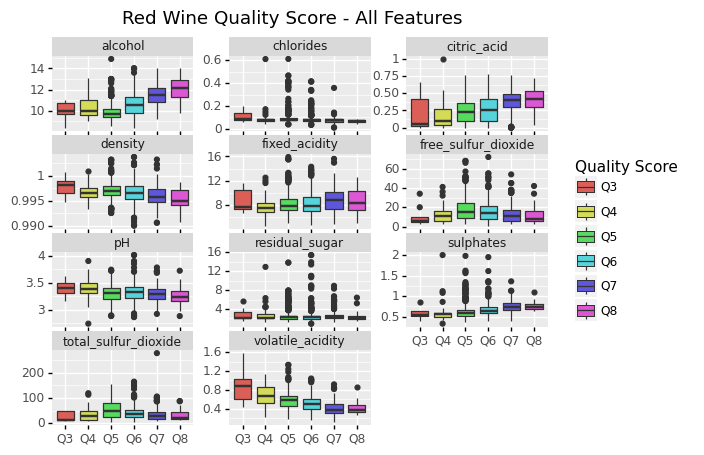

<ggplot: (8778605406461)>

In [6]:
(ggplot(table_1, aes(x="quality1", y="value")) + 
 geom_boxplot(aes(fill = "quality1")) + 
 facet_wrap('~ features', ncol = 3, scales = "free") +
 theme(subplots_adjust={'wspace': 0.25, 'hspace': 0.3}) +
 labs(title = "Red Wine Quality Score - All Features",
      fill = "Quality Score",
      x = "",
      y = ""))

Text(0.5, 1.0, 'Red Wine Physicochemical Properties')

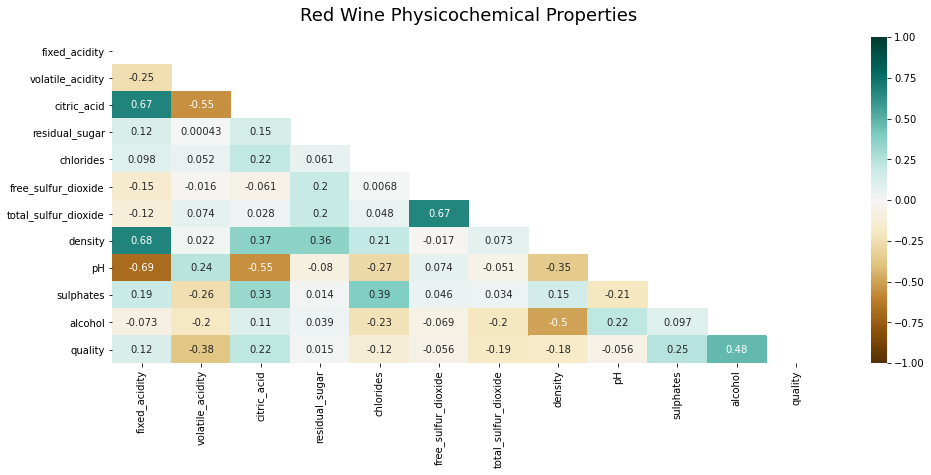

In [7]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train_set.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_set.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Red Wine Physicochemical Properties', fontdict={'fontsize':18}, pad=16)

The QQ plots compare the feature distribution with the normal distribution, but considering the wine quality score prevalence (the bar chart) we are wondering if linear regression model can perform well for extreme cases (lower or higher quality) just because a majority of the quality values are “Medium” (5 and 6) and this could sabotage the model performance. The box plots help us notice that all features have outliers that we are going to exclude from the train set. Not all variables are highly correlated with the response. We see that critic_acid, alcohol, and sulphates are in a positive relationship with it, while volatile_acidity, density, and pH are negatively correlated with variable quality. The correlogram shows the correlation of all predictors in pairs, so by deciding that low correlation is between -0.5 and 0.5, and high correlation otherwise, we can conclude that correlation of variables is low. Anyway, it’s okay to start with linear regression just to have a basic sense of the relationship between the response and features.

In [8]:
# Remove outliers
train_set = train_set.iloc[:, 0:12]
print(f"number of data entires: {len(train_set)}")
for feature in train_set:
    f = train_set[feature].values
    mean = np.mean(f)
    std = np.std(f)
    n = len(f)
    count = 0
    for i in range (0,n):
        z = (f[i] - mean) / std
        if (z>5) :
            count = count + 1
            train_set = train_set.drop([i])
    print(f"{count} {feature}'s have been dropped")
    train_set = train_set.reset_index(drop=True)

number of data entires: 1439
0 fixed_acidity's have been dropped
1 volatile_acidity's have been dropped
0 citric_acid's have been dropped
10 residual_sugar's have been dropped
22 chlorides's have been dropped
2 free_sulfur_dioxide's have been dropped
1 total_sulfur_dioxide's have been dropped
0 density's have been dropped
0 pH's have been dropped
4 sulphates's have been dropped
0 alcohol's have been dropped
0 quality's have been dropped


In [9]:
# Linear Regression
X_train = train_set.iloc[:, 0:11]
X_test = test_set.iloc[:, 0:11]
y_train_s = train_set['quality']
y_test_s = test_set['quality']

from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X_train, y_train_s)
y_pred_s = regr.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test_s, y_pred_s))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test_s, y_pred_s))

Coefficients: 
 [ 9.64820212e-03 -9.59635609e-01 -1.98888276e-01 -1.51029233e-03
 -1.38285546e+00  3.02782955e-03 -3.16703608e-03 -1.55755578e+01
 -5.92807608e-01  1.22831035e+00  2.86067582e-01]
Mean squared error: 0.29
Coefficient of determination: 0.42


As we can see above in the model summary, the R-squared of the model is 0.42 and it seems that by using some other method we could achieve a higher accuarcy. We removed outliers, but let's see if linear regression still can perform better using feature selection method or selecting all features is the best we can do in terms of achieving the highest accuracy.
We are going to use Recursive Feature Elimination, method that selects features by considering a smaller set of regressors. Less important regressors are recursively pruned from the initial set and the procedure is repeated until specified number of features remain. This number is 5 by default.

In [10]:
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

from sklearn.feature_selection import RFE
X = X_train
y = y_train_s
names=pd.DataFrame(X_train.columns)

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(regr, step=1) # "n_features_to_select = 5" - by default
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.
y_pred_rfe = rfe_mod.predict(X_test)

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
rankings

#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test_s, y_pred_rfe))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test_s, y_pred_rfe))

            Feature  Rank
1  volatile_acidity     1
4         chlorides     1
7           density     1
8                pH     1
9         sulphates     1
Mean squared error: 0.36
Coefficient of determination: 0.28


Coefficient of determination is not as high as before and on top of that the variable alcohol is not selected either. As we remember this variable is of high importance, but we missed to select using this method. We could investigate how this variable is ranked, but the better option is to use Recursive Feature Elimination with cross-validation. This method is designed to optimally find the best subset of regressors.

In [11]:
from sklearn.feature_selection import RFECV

#This is to select 5 variables: can be changed and checked in model for accuracy
rfecv_mod =  RFECV(regr, step=1, cv=300)
myvalues_cv=rfecv_mod.fit(X,y) #to fit
myvalues_cv.support_#The mask of selected features.
myvalues_cv.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.
y_pred_rfecv = rfecv_mod.predict(X_test)

rankings_cv=pd.DataFrame(myvalues_cv.ranking_) #Make it into data frame
rankings_cv

#Concat and name columns
ranked_cv=pd.concat([names,rankings_cv], axis=1)
ranked_cv.columns = ["Feature", "Rank"]
ranked_cv

#Select most important (Only 1's)
most_important_cv = ranked_cv.loc[ranked_cv['Rank'] ==1] 
print(most_important_cv)

most_important_cv['Rank'].count()

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test_s, y_pred_rfecv))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test_s, y_pred_rfecv))

                 Feature  Rank
0          fixed_acidity     1
1       volatile_acidity     1
2            citric_acid     1
4              chlorides     1
5    free_sulfur_dioxide     1
6   total_sulfur_dioxide     1
7                density     1
8                     pH     1
9              sulphates     1
10               alcohol     1
Mean squared error: 0.29
Coefficient of determination: 0.42


This model indicates that we should keep all features and try implementing some other machine learning model.

In [12]:
# Decission Tree
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train_s)
y_pred_dt = dt.predict(X_test)
print(classification_report(y_test_s, y_pred_dt, labels=np.unique(y_pred_dt)))

              precision    recall  f1-score   support

           4       0.25      0.50      0.33         2
           5       0.79      0.75      0.77        69
           6       0.68      0.65      0.67        72
           7       0.42      0.50      0.46        16
           8       0.00      0.00      0.00         0

   micro avg       0.68      0.68      0.68       159
   macro avg       0.43      0.48      0.45       159
weighted avg       0.70      0.68      0.69       159



/Users/uroszivanovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


We build decission tree in order achieve better model flexibility, even though it provides higher accuary it does not perform well either in terms of predicting extreme cases. This method is easy to read and understand, and it can model human decision process. However, they don’t have the best accuracy, they are hard to train and they are unstable in changes in the data.

Classifying wines with low, medium, and high quality levels might be good option especially in a situation when the data set is not well balanced. Before doing that let's try kNN to see if the higher model accuracy could be achieved with this model. The k-nearest neighbors algorithm estimates the conditional probability by calculating the euclidean distance of all predictors, then for any point in the multidimensional space that we want to predict. Number of points k is a tuning parameter that can be calculated running the algorithm for several values of k and picking the best result.

In [13]:
# Create kNN classifier and see what value of k is best
from sklearn.neighbors import KNeighborsClassifier
max = 0
rng = [3, 5, 7, 9, 11, 13, 15]
for i in ( rng ) :
    knni = KNeighborsClassifier (n_neighbors = i)
    # fitting the data
    knni.fit (X_train, y_train_s)
    percent =round(100* knni.score( X_train, y_train_s), 2)
    print (f"nearest neighbor {i}, quality: {percent}%")
    if (percent > max ) :
        max = percent
        index = i
print(f"kNN with {index} nearest neighbor percent accuracy: {max}%")

nearest neighbor 3, quality: 74.62%
nearest neighbor 5, quality: 65.4%
nearest neighbor 7, quality: 61.47%
nearest neighbor 9, quality: 58.68%
nearest neighbor 11, quality: 58.76%
nearest neighbor 13, quality: 57.18%
nearest neighbor 15, quality: 57.54%
kNN with 3 nearest neighbor percent accuracy: 74.62%


In [14]:
# Refitting the data for the kNN test
knn = KNeighborsClassifier (n_neighbors = 3)
knn.fit (X_test, y_test_s)
percent = round(100* knn.score( X_test , y_test_s), 2)
print(f"k: {index}, percent accuracy {percent}%")
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test_s, y_pred_knn, labels=np.unique(y_pred_knn)))

k: 3, percent accuracy 71.25%
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.50      1.00      0.67         2
           5       0.73      0.74      0.73        69
           6       0.75      0.82      0.78        72
           7       0.50      0.12      0.20        16

    accuracy                           0.71       160
   macro avg       0.50      0.54      0.48       160
weighted avg       0.71      0.71      0.70       160



We succeeded in improving the accuracy with kNN, now let's check if we can do better by grouping quality levels.

In [15]:
# Create categorical variable called 'quality2' with Low, Medium, and High quality levels
train_set.loc[:,'quality2'] = np.select(
    [
        train_set['quality'].between(3, 4, inclusive=True), 
        train_set['quality'].between(5, 6, inclusive=True),
        train_set['quality'].between(7, 8, inclusive=True)
    ], 
    [
        'Low', 
        'Medium',
        'High'
    ]
)

train_set.loc[:,'quality2'] = train_set.loc[:, 'quality2'].astype("category")

test_set.loc[:,'quality2'] = np.select(
    [
        test_set['quality'].between(3, 4, inclusive=True), 
        test_set['quality'].between(5, 6, inclusive=True),
        test_set['quality'].between(7, 8, inclusive=True)
    ], 
    [
        'Low', 
        'Medium',
        'High'
    ]
)

test_set.loc[:,'quality2'] = test_set.loc[:, 'quality2'].astype("category")


qual_ord = CategoricalDtype(categories=['Low', 'Medium', 'High'], ordered=True)
train_set.loc[:, 'quality2'] = train_set.loc[:, 'quality2'].astype(qual_ord)
test_set.loc[:, 'quality2'] = test_set.loc[:, 'quality2'].astype(qual_ord)

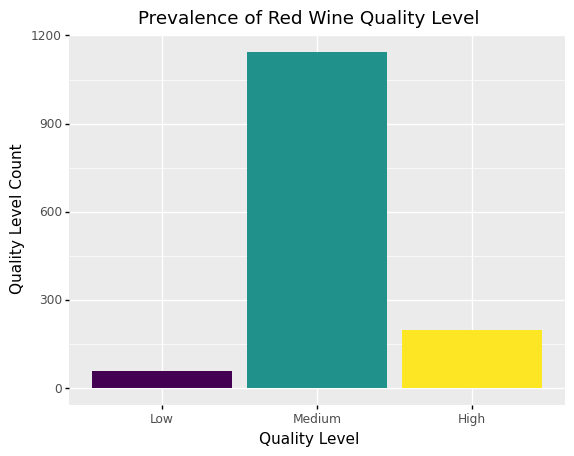

<ggplot: (8778606760957)>

In [16]:
(ggplot(train_set) + geom_bar(aes("quality2", fill = "quality2")) +
 theme(legend_position = "none") +
 labs(
         title ='Prevalence of Red Wine Quality Level',
         x = 'Quality Level',
         y = 'Quality Level Count',
     ))

In [17]:
table_2=train_set.melt(id_vars='quality2', value_vars=predictors, var_name='features', value_name='value')

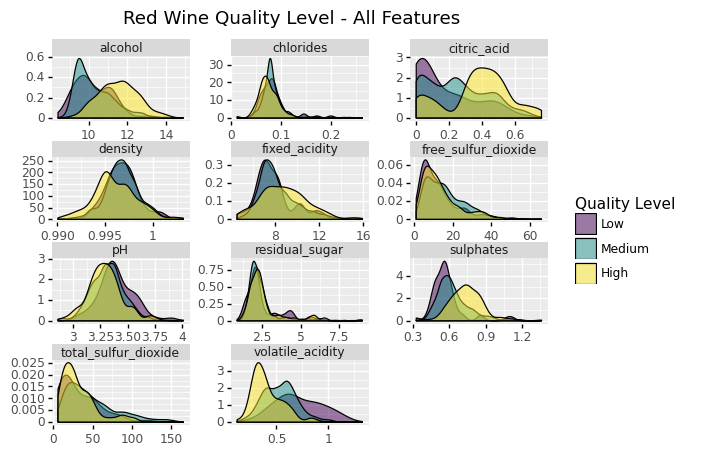

<ggplot: (8778598389128)>

In [18]:
(ggplot(table_2) + 
 geom_density(aes(x = "value", fill = "quality2"), alpha = 0.5) +
 facet_wrap('~ features', ncol = 3, scales = "free") +
 theme(subplots_adjust={'wspace': 0.30, 'hspace': 0.55}) +
 labs(title = "Red Wine Quality Level - All Features",
      fill = "Quality Level",
      x = "",
      y = ""))

In [19]:
# create response for this purpose
y_train_l = train_set['quality2']
y_test_l = test_set['quality2']

In [20]:
# Decission Tree (Quality Levels)
dt2 = DecisionTreeClassifier(random_state=1)
dt2.fit(X_train, y_train_l)
y_pred_dt2 = dt2.predict(X_test)
print(classification_report(y_test_l, y_pred_dt2, labels=np.unique(y_pred_dt2)))

              precision    recall  f1-score   support

        High       0.50      0.50      0.50        16
         Low       0.22      0.67      0.33         3
      Medium       0.93      0.89      0.91       141

    accuracy                           0.85       160
   macro avg       0.55      0.69      0.58       160
weighted avg       0.88      0.85      0.86       160



In [21]:
# Create kNN classifier and see what value of k is best (Quality Levels)
max = 0
rng = [3, 5, 7, 9, 11, 13, 15]
for i in ( rng ) :
    knni2 = KNeighborsClassifier (n_neighbors = i)
    # fitting the data
    knni2.fit (X_train, y_train_l)
    percent =round(100* knni2.score( X_train, y_train_l), 2)
    print (f"nearest neighbor {i}, quality: {percent}%")
    if (percent > max ) :
        max = percent
        index = i
print(f"kNN with {index} nearest neighbor percent accuracy: {max}%")

nearest neighbor 3, quality: 89.35%
nearest neighbor 5, quality: 87.42%
nearest neighbor 7, quality: 85.42%
nearest neighbor 9, quality: 84.49%
nearest neighbor 11, quality: 83.2%
nearest neighbor 13, quality: 82.92%
nearest neighbor 15, quality: 82.92%
kNN with 3 nearest neighbor percent accuracy: 89.35%


In [22]:
# Refitting the data for the kNN test (Quality Levels)
knn2 = KNeighborsClassifier (n_neighbors = 3)
knn2.fit (X_test, y_test_l)
percent = round(100* knn2.score( X_test , y_test_l), 2)
print(f"k: {index}, percent accuracy {percent}%")
y_pred_knn2 = knn2.predict(X_test)
print(classification_report(y_test_l, y_pred_knn2, labels=np.unique(y_pred_knn2)))

k: 3, percent accuracy 88.75%
              precision    recall  f1-score   support

        High       0.60      0.19      0.29        16
      Medium       0.90      0.99      0.94       141

   micro avg       0.89      0.90      0.90       157
   macro avg       0.75      0.59      0.61       157
weighted avg       0.87      0.90      0.87       157



Most wines are of regular quality (the bar chart), but grouping quality levels made a model accuracy improvement (notice the higher accuracy of new decission tree and KNN models). The distribution overlaps for quality levels of most of the predictors (the density plot). This means that no single feature alone is not enough to achieve high prediction accuracy. 

So we have built several models to predict wine quality (Score or Level), but we are not impressed by the results. Considering that wine quality score ranges from 1 to 10, this performance is not acceptable. The very first option in real application should be to gather more data and perform feature engineering, but since the purpose of this task is to show skills and express creativity, we have to rely on the existing data set. Accordingly, we are going to build the model Random Forest (known for its ability to achieve high prediction accuracy - very high specificity and sensitivity) and introduce the concept of hyperparameter tuning (the settings of an algorithm that can be adjusted to optimize performance) that relies more on experimental results than theory.

In [23]:
# Take a look at the available hyperparameters and create a random forest and examine the default values
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 1)
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


There are lots of them but the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features) are known for being the most important settings. 

We will use RandomizedSearchCV and in order to do that we will create a parameter grid to help us randomly choose different combinations of the features, on each iteration.

In [24]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Random search training with n_iter and cv numbers defined in order to achieve the trade-off, best possible performance (with the chance of overfitting greatly reduced) and the run time.

In [25]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train_s)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [26]:
# best parameters from fitting the random search
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [27]:
# evaluate Random Search
def evaluate(rf_random, X_test, y_test_s):
    predictions = rf_random.predict(X_test)
    errors = abs(predictions - y_test_s)
    mape = 100 * np.mean(errors / y_test_s)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 1)
base_model.fit(X_train, y_train_s)
base_accuracy = evaluate(base_model, X_test, y_test_s)

Model Performance
Average Error: 0.3750 degrees.
Accuracy = 93.17%.


By comparing the base model with the best random search model we notice that we've achieved a small improvement in accuracy.

In [28]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test_s)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.3539 degrees.
Accuracy = 93.50%.
Improvement of 0.35%.


For further improvement of our results we will use Grid Search with Cross-Validation. To use Grid Search, we make another grid based on the best values provided by Random Search.

In [29]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

We fit the model, displayed the best hyperparameters, and evaluated performance. It seems that we maxed out performance.

In [30]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train_s)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.9min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [31]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test_s)

Model Performance
Average Error: 0.3783 degrees.
Accuracy = 93.09%.


In [32]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of -0.09%.


Considering all results it seems that the random forest model has the best performance with 93% and is the best choice for real application. However, once again we should point out the limitations of this analysis. First, we deal with an unbalanced dataset where a majority of the quality values are "Medium" (5 and 6). Second, in real life (a job related to the wine industry) we would be working on a data set containing information on wine quality scores ranging from 1 to 10. Third, feature engineering to include more relevant data points such as: year of harvest, brew time, location, wine type, average growing season temperature, harvest rain, winter rain -  in short, the most important information that will help us to improve our business within the wine industry as efficiently as possible.